In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-14 21:28:57.203628: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-14 21:28:58.567683: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-14 21:28:58.611697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-14 21:28:58.611746: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-14 21:28:58.629662: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-14 21:28:58.629734: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-14 21:28:58.635259: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

eco_gen_GASF_60m_300S0X_2_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 8.877756286266925, 1: 0.15678009523354078, 2: 0.6806762568589648, 3: 2.9301583248212464, 4: 3.202260517686458, 5: 4.176722176722177, 6: 1.1790182126435305, 7: 2.295129512951295, 8: 1.5334602920049447, 9: 8.934786840568425, 10: 10.103015628439357}
 
Tests 
HEKA test: 117 train: 470
fridge/freezer test: 6654 train: 26614
HTPC test: 1533 train: 6130
audio system test: 356 train: 1424
broadband router test: 326 train: 1303
coffee maker test: 249 train: 999
computer test: 885 train: 3539
lamp test: 455 train: 1818
laptop computer test: 680 train: 2721
microwave test: 117 train: 467
washing machine test: 103 train: 413


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/eco/TL/eco_82_iawe,redd_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data eco training on model iawe seed 82
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 8.877756286266925, 1: 0.15678009523354078, 2: 0.6806762568589648, 3: 2.9301583248212464, 4: 3.202260517686458, 5: 4.176722176722177, 6: 1.1790182126435305, 7: 2.295129512951295, 8: 1.5334602920049447, 9: 8.934786840568425, 10: 10.103015628439357}
 
Tests 
HEKA test: 117 train: 470
fridge/freezer test: 6654 train: 26614
HTPC test: 1533 train: 6130
audio system test: 356 train: 1424
broadband router test: 326 train: 1303
coffee maker test: 249 train: 999
computer test: 885 train: 3539
lamp test: 455 train: 1818
laptop computer test: 680 train: 2721
microwave test: 117 train: 467
washing machine test: 103 train: 413
loading model
compling TL model..


2022-02-14 21:29:04.303857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-14 21:29:04.305477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-14 21:29:04.305746: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-14 21:29:05.183316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-14 21:29:05.183379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-14 21:29:05.183458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-14 21:29:05.184477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-14 21:29:05.759534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-14 21:29:05.780516: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/25


2022-02-14 21:29:06.274958: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-14 21:29:06.985124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-14 21:29:07.839995: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-14 21:29:08.596809: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1435/1435 - 75s - loss: 2.3075 - accuracy: 0.4454
Epoch 2/25
1435/1435 - 72s - loss: 1.8593 - accuracy: 0.1779
Epoch 3/25
1435/1435 - 72s - loss: 1.7080 - accuracy: 0.1921
Epoch 4/25
1435/1435 - 71s - loss: 1.5568 - accuracy: 0.3104
Epoch 5/25
1435/1435 - 71s - loss: 1.6884 - accuracy: 0.1977
Epoch 6/25
1435/1435 - 71s - loss: 1.5229 - accuracy: 0.2941
Epoch 7/25
1435/1435 - 71s - loss: 1.6301 - accuracy: 0.2685
Epoch 8/25
1435/1435 - 71s - loss: 1.4180 - accuracy: 0.3543
Epoch 9/25
1435/1435 - 71s - loss: 1.4029 - accuracy: 0.4309
Epoch 10/25
1435/1435 - 71s - loss: 1.4491 - accuracy: 0.3610
Epoch 11/25
1435/1435 - 71s - loss: 1.3969 - accuracy: 0.3774
Epoch 12/25
1435/1435 - 72s - loss: 1.2495 - accuracy: 0.4454
Epoch 13/25
1435/1435 - 71s - loss: 1.4616 - accuracy: 0.4485
Epoch 14/25
1435/1435 - 71s - loss: 1.4035 - accuracy: 0.3935
Epoch 15/25
1435/1435 - 70s - loss: 1.3352 - accuracy: 0.4151
Epoch 16/25
1435/1435 - 70s - loss: 1.2531 - accuracy: 0.5193
Epoch 17/25
1435/1435 - 70s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/25
1435/1435 - 73s - loss: 2.4169 - accuracy: 0.0480
Epoch 2/25
1435/1435 - 71s - loss: 2.3987 - accuracy: 0.0592
Epoch 3/25
1435/1435 - 71s - loss: 2.3986 - accuracy: 0.0492
Epoch 4/25
1435/1435 - 71s - loss: 2.3985 - accuracy: 0.1655
Epoch 5/25
1435/1435 - 71s - loss: 2.3987 - accuracy: 0.0471
Epoch 6/25
1435/1435 - 71s - loss: 2.3985 - accuracy: 0.0807
Epoch 7/25
1435/1435 - 71s - loss: 2.3988 - accuracy: 0.0305
Epoch 8/25
1435/1435 - 71s - loss: 2.3988 - accuracy: 0.0599
Epoch 9/25
1435/1435 - 71s - loss: 2.3987 - accuracy: 0.0744
Epoch 10/25
1435/1435 - 71s - loss: 2.3987 - accuracy: 0.0939
Epoch 11/25
1435/1435 - 71s - loss: 2.3986 - accuracy: 0.0245
Epoch 12/25
1435/1435 - 71s - loss: 2.3987 - accuracy: 0.0614
Epoch 13/25
1435/1435 - 71s - loss: 2.3986 - accuracy: 0.0297
Epoch 14/25
1435/1435 - 71s - loss: 2.3988 - accuracy: 0.0845
Epoch 15/25
1435/1435 - 71s - loss: 2.3987 - accuracy: 0.0242
Epoch 16/25
1435/1435 - 71s - loss: 2.3987 - a

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


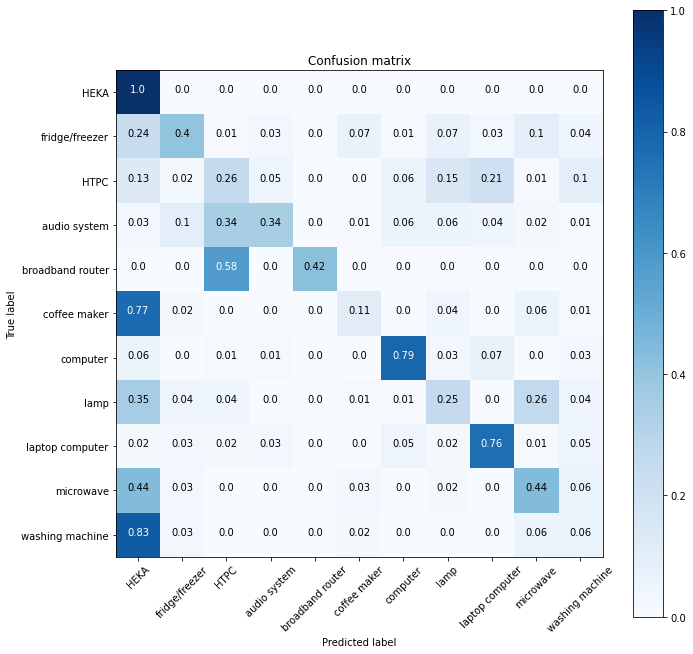

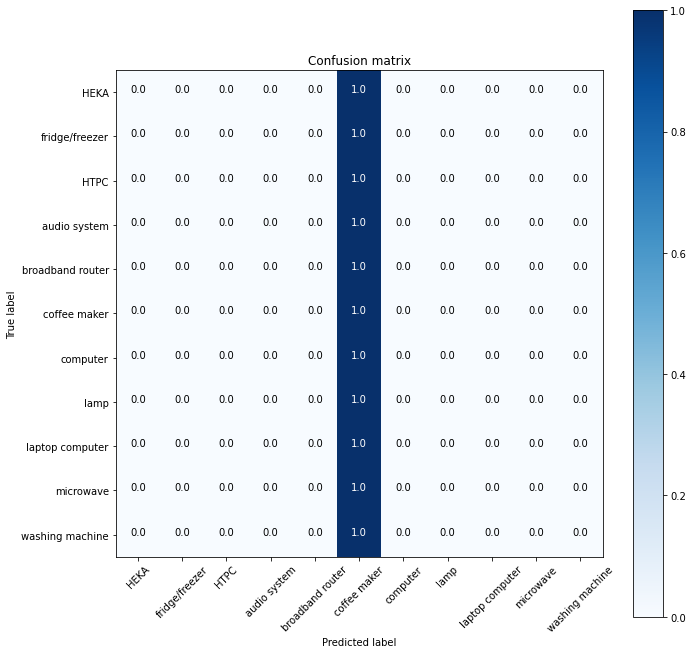

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()